# Load Volve models and train model autoencoder

In [1]:
from __future__ import print_function
#load libraries
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter

import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import time
import scipy.io as sio
import math
import pandas as pd
import subprocess
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
M0 = np.load("data/M0.npy")
print(M0.shape)
print(np.min(M0))
print(np.max(M0))

(124, 78, 87, 15)
-99.0
0.35714301466941833


In [3]:
#set all-99 to 0
M0 = np.where(M0 == -99, 0, M0)
print(np.min(M0))
print(np.max(M0))

0.0
0.35714301466941833


In [4]:
import matplotlib as m

def plot(samples, z_sz):
    fig = plt.figure(figsize=(15, 8))
    gs = gridspec.GridSpec(3, 5)
    gs.update(wspace=0.1, hspace=0.1)

    for i in range(z_sz):
        sample = samples[:,:,i]
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.imshow(sample, aspect='equal', cmap='jet', vmin=0, vmax=0.35)
        
def plotFree(samples, z_sz):
    fig = plt.figure(figsize=(15, 8))
    gs = gridspec.GridSpec(3, 5)
    gs.update(wspace=0.1, hspace=0.1)

    for i in range(z_sz):
        sample = samples[:,:,i]
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.imshow(sample, aspect='equal', cmap='jet')    

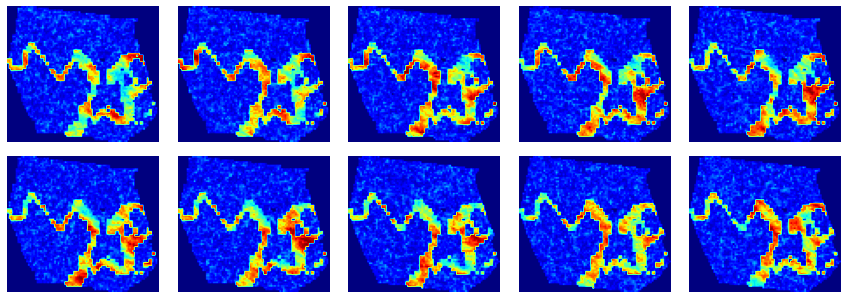

In [5]:
plot(M0[43,:,:,:], 10)

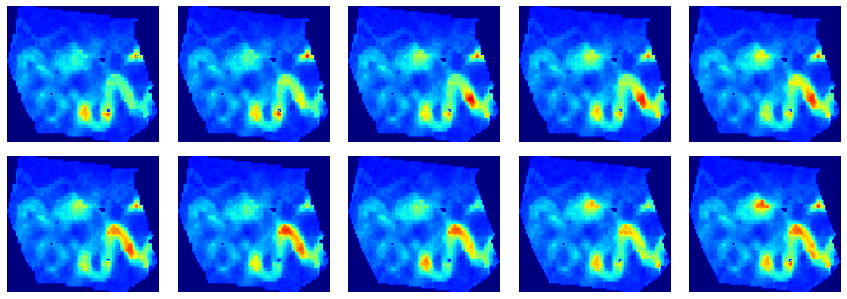

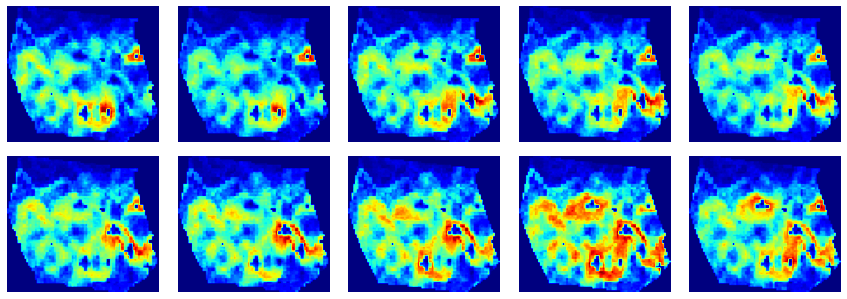

In [6]:
#minus the mean from the realizations
M0_mean = np.mean(M0, axis=0)
M0_var = np.var(M0, axis=0)

plot(M0_mean, 10)
plotFree(M0_var, 10)

In [7]:
Mtrain = np.expand_dims(M0, axis=4)
print(Mtrain.shape)

(124, 78, 87, 15, 1)


# Model Autoencoder

In [8]:
#define Keras classes

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

from tensorflow.keras.layers import Dense, Dropout, Flatten, Multiply, Reshape
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from tensorflow.keras.layers import Input, UpSampling2D, UpSampling3D
from tensorflow.keras import backend as K

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from IPython.display import clear_output

from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector

from tensorflow.keras.callbacks import History 

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss", c = 'green')
        plt.plot(self.x, self.val_losses, label="val_loss", c = 'red')
        plt.legend()
        plt.show()

In [9]:
#define model encoder decoder
input_dt2 = Input(shape=(78, 87, 15, 1)) 

# define model encoder
_ = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(input_dt2)
_ = MaxPooling3D((2, 2, 2), padding='same')(_)
_ = Conv3D(8, (4, 4, 4), activation='relu', padding='same')(_)
_ = MaxPooling3D((2, 2, 2), padding='same')(_)
_ = Conv3D(4, (5, 5, 5), activation='relu', padding='same')(_)
_ = MaxPooling3D((2, 2, 2), padding='same')(_)
_ = Reshape((10*11*2*4,))(_)
encoded_m2 = Dense(64, activation='linear')(_)

#model decoder
_ = Dense((11*12*3*4), activation='linear')(encoded_m2)
_ = Reshape((11, 12, 3, 4))(_)
_ = Conv3D(4, (5, 5, 5), activation='relu', padding='same')(_)
_ = UpSampling3D((2, 2, 2))(_)
_ = Conv3D(8, (4, 4, 4), activation='relu', padding='same')(_)
_ = UpSampling3D((2, 2, 2))(_)
_ = Conv3D(16, (3, 3, 3), activation='relu')(_)
_ = UpSampling3D((2, 2, 2))(_)
output_img = Conv3D(1, (7, 6, 6), activation='linear', padding='valid')(_)

# define model and compile
LSI_modelAE = Model(input_dt2, output_img)
opt = keras.optimizers.Adam(lr=1e-3)
LSI_modelAE.compile(optimizer=opt, loss='mean_squared_error')
LSI_modelAE.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 78, 87, 15, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 78, 87, 15, 16)    448       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 39, 44, 8, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 39, 44, 8, 8)      8200      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 20, 22, 4, 8)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 20, 22, 4, 4)      4004      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 10, 11, 2, 4)      0     

D:\13108\anaconda3\envs\Py36\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


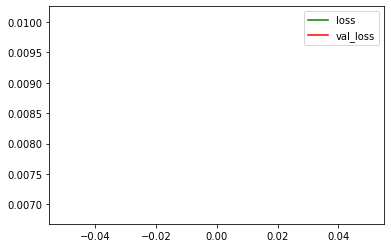

In [10]:
plot_losses = PlotLosses()
LSI_modelAE.fit(Mtrain, Mtrain,        
                epochs=10,
                batch_size=32,
                shuffle=True,
                validation_split=0.1,
                callbacks=[plot_losses])

In [11]:
#predict both vars
Mtrain_hat = LSI_modelAE.predict(Mtrain)
Mtrain_hat = np.squeeze(Mtrain_hat)

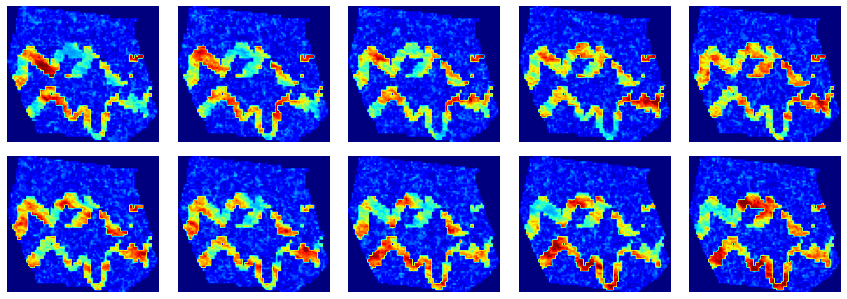

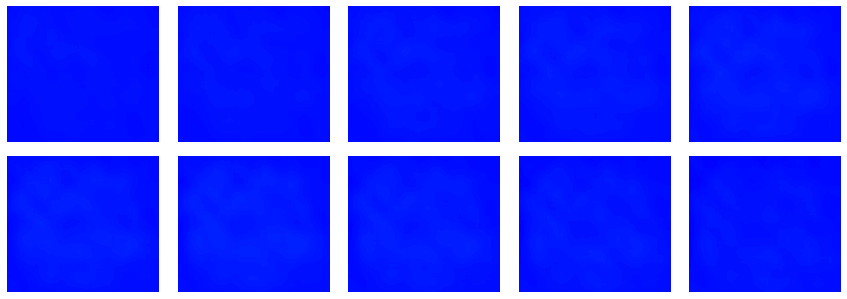

In [12]:
train_case = 10
plot(np.squeeze(Mtrain[train_case,:,:,:]), 10)
plot(Mtrain_hat[train_case,:,:,:], 10)

Text(0.5, 1.0, 'Training data')

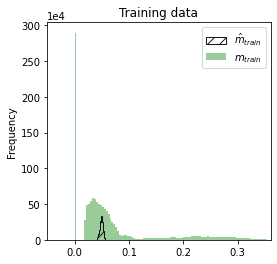

In [13]:
def RMSE(data1, data2):
    return np.sqrt(np.mean((data1.flatten()-data2.flatten())**2))

ax = plt.figure(figsize=[4, 4])
plt.hist(Mtrain.flatten(), bins=100, color="g", alpha=0.4, )
plt.hist(Mtrain_hat.flatten(), bins=100, color="k", alpha=0.9, hatch='//', edgecolor='black', histtype='step', )
plt.legend(['$\hat{m}_{train}$', '$m_{train}$'])
plt.xlim([-0.05, 0.36])
plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
plt.ylabel("Frequency")
plt.title('Training data')